In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.rnn import rnn

2023-07-22 23:24:16.123018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 23:24:17.444255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [6]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
rnn_unit1 = 64
rnn_unit2 = 32
rnn_unit3 = 16
l1_reg = 1e-5
l2_reg = 1e-5
dropout=0.2
masked_value = 1e-10

learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [7]:
model = rnn(input_shape=input_shape,
            rnn_unit1=rnn_unit1,
            rnn_unit2=rnn_unit2,
            rnn_unit3=rnn_unit3,
            l1_reg=l1_reg, 
            l2_reg=l2_reg, 
            dropout=dropout,
            masked_value=masked_value
            )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 96, 32)            1568      
                                                                 
 dropout (Dropout)           (None, 96, 32)            0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 96)                295008    
                                                                 
Total params: 296576 (1.13 MB)
Trainable params: 296576 (1.13

2023-07-22 23:24:24.851541: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [8]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/rnn_gate_pump.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 23:24:28.262920: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efef8006c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 23:24:28.262974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 23:24:28.273731: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 23:24:28.506833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 23:24:28.914643: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.07494, saving model to saved_models/rnn_gate_pump.h5
151/151 - 18s - loss: 0.0467 - mae: 0.1546 - val_loss: 0.0123 - val_mae: 0.0749 - 18s/epoch - 120ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.07494 to 0.06319, saving model to saved_models/rnn_gate_pump.h5
151/151 - 14s - loss: 0.0194 - mae: 0.1004 - val_loss: 0.0094 - val_mae: 0.0632 - 14s/epoch - 89ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.06319 to 0.05826, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0140 - mae: 0.0825 - val_loss: 0.0083 - val_mae: 0.0583 - 13s/epoch - 87ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05826 to 0.05470, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0110 - mae: 0.0707 - val_loss: 0.0076 - val_mae: 0.0547 - 13s/epoch - 87ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05470 to 0.05234, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0091 - mae: 0.0622 - val_loss: 0.0071 - val_mae: 0.0523 - 13s/epoch - 85ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05234 to 0.05080, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0078 - mae: 0.0557


Epoch 41: val_mae improved from 0.03048 to 0.03017, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0015 - mae: 0.0158 - val_loss: 0.0024 - val_mae: 0.0302 - 13s/epoch - 87ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.03017 to 0.02998, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0014 - mae: 0.0157 - val_loss: 0.0024 - val_mae: 0.0300 - 13s/epoch - 86ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.02998 to 0.02997, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 0.0014 - mae: 0.0155 - val_loss: 0.0024 - val_mae: 0.0300 - 13s/epoch - 87ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.02997 to 0.02953, saving model to saved_models/rnn_gate_pump.h5
151/151 - 14s - loss: 0.0013 - mae: 0.0154 - val_loss: 0.0023 - val_mae: 0.0295 - 14s/epoch - 91ms/step
Epoch 45/3000

Epoch 45: val_mae improved from 0.02953 to 0.02950, saving model to saved_models/rnn_gate_pump.h5
151/151 - 14s - loss: 0.0013 - ma

Epoch 82/3000

Epoch 82: val_mae did not improve from 0.02390
151/151 - 14s - loss: 4.8587e-04 - mae: 0.0121 - val_loss: 0.0012 - val_mae: 0.0241 - 14s/epoch - 92ms/step
Epoch 83/3000

Epoch 83: val_mae improved from 0.02390 to 0.02349, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 4.7788e-04 - mae: 0.0121 - val_loss: 0.0011 - val_mae: 0.0235 - 13s/epoch - 88ms/step
Epoch 84/3000

Epoch 84: val_mae improved from 0.02349 to 0.02253, saving model to saved_models/rnn_gate_pump.h5
151/151 - 14s - loss: 4.6999e-04 - mae: 0.0121 - val_loss: 0.0010 - val_mae: 0.0225 - 14s/epoch - 92ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.02253
151/151 - 13s - loss: 4.6174e-04 - mae: 0.0120 - val_loss: 0.0011 - val_mae: 0.0232 - 13s/epoch - 89ms/step
Epoch 86/3000

Epoch 86: val_mae did not improve from 0.02253
151/151 - 13s - loss: 4.5476e-04 - mae: 0.0120 - val_loss: 0.0010 - val_mae: 0.0226 - 13s/epoch - 87ms/step
Epoch 87/3000

Epoch 87: val_mae improved from 0

151/151 - 13s - loss: 3.5306e-04 - mae: 0.0112 - val_loss: 0.0011 - val_mae: 0.0254 - 13s/epoch - 85ms/step
Epoch 129/3000

Epoch 129: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.5131e-04 - mae: 0.0112 - val_loss: 9.8796e-04 - val_mae: 0.0237 - 13s/epoch - 89ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.5091e-04 - mae: 0.0112 - val_loss: 0.0011 - val_mae: 0.0252 - 13s/epoch - 86ms/step
Epoch 131/3000

Epoch 131: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.4902e-04 - mae: 0.0112 - val_loss: 0.0011 - val_mae: 0.0251 - 13s/epoch - 87ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.4881e-04 - mae: 0.0112 - val_loss: 0.0011 - val_mae: 0.0250 - 13s/epoch - 84ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.4838e-04 - mae: 0.0112 - val_loss: 0.0010 - val_mae: 0.0245 - 13s/epoch - 86ms/step
Epoch 134/3000

Epoch 134: v

Epoch 176/3000

Epoch 176: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1655e-04 - mae: 0.0108 - val_loss: 9.9913e-04 - val_mae: 0.0245 - 13s/epoch - 84ms/step
Epoch 177/3000

Epoch 177: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1566e-04 - mae: 0.0108 - val_loss: 0.0011 - val_mae: 0.0257 - 13s/epoch - 84ms/step
Epoch 178/3000

Epoch 178: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1556e-04 - mae: 0.0108 - val_loss: 0.0011 - val_mae: 0.0263 - 13s/epoch - 85ms/step
Epoch 179/3000

Epoch 179: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1509e-04 - mae: 0.0108 - val_loss: 0.0011 - val_mae: 0.0253 - 13s/epoch - 88ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1502e-04 - mae: 0.0108 - val_loss: 9.7881e-04 - val_mae: 0.0242 - 13s/epoch - 84ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.02192
151/151 - 13s - loss: 3.1441e-04 - mae: 0.0108 - val_loss: 0.0010 - 

Epoch 223/3000

Epoch 223: val_mae did not improve from 0.02174
151/151 - 13s - loss: 2.9616e-04 - mae: 0.0106 - val_loss: 8.6847e-04 - val_mae: 0.0228 - 13s/epoch - 87ms/step
Epoch 224/3000

Epoch 224: val_mae did not improve from 0.02174
151/151 - 13s - loss: 2.9578e-04 - mae: 0.0106 - val_loss: 9.0192e-04 - val_mae: 0.0233 - 13s/epoch - 87ms/step
Epoch 225/3000

Epoch 225: val_mae did not improve from 0.02174
151/151 - 14s - loss: 2.9668e-04 - mae: 0.0106 - val_loss: 8.5227e-04 - val_mae: 0.0226 - 14s/epoch - 91ms/step
Epoch 226/3000

Epoch 226: val_mae did not improve from 0.02174
151/151 - 13s - loss: 2.9572e-04 - mae: 0.0106 - val_loss: 8.7584e-04 - val_mae: 0.0230 - 13s/epoch - 86ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.02174
151/151 - 13s - loss: 2.9594e-04 - mae: 0.0106 - val_loss: 8.1765e-04 - val_mae: 0.0219 - 13s/epoch - 85ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.02174
151/151 - 13s - loss: 2.9588e-04 - mae: 0.0106 - val_los

Epoch 269/3000

Epoch 269: val_mae did not improve from 0.02011
151/151 - 13s - loss: 2.8405e-04 - mae: 0.0105 - val_loss: 7.7739e-04 - val_mae: 0.0213 - 13s/epoch - 88ms/step
Epoch 270/3000

Epoch 270: val_mae did not improve from 0.02011
151/151 - 13s - loss: 2.8407e-04 - mae: 0.0105 - val_loss: 7.2160e-04 - val_mae: 0.0203 - 13s/epoch - 86ms/step
Epoch 271/3000

Epoch 271: val_mae did not improve from 0.02011
151/151 - 13s - loss: 2.8364e-04 - mae: 0.0105 - val_loss: 7.4834e-04 - val_mae: 0.0208 - 13s/epoch - 86ms/step
Epoch 272/3000

Epoch 272: val_mae did not improve from 0.02011
151/151 - 13s - loss: 2.8314e-04 - mae: 0.0105 - val_loss: 7.1137e-04 - val_mae: 0.0201 - 13s/epoch - 89ms/step
Epoch 273/3000

Epoch 273: val_mae improved from 0.02011 to 0.01998, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 2.8325e-04 - mae: 0.0105 - val_loss: 7.0445e-04 - val_mae: 0.0200 - 13s/epoch - 85ms/step
Epoch 274/3000

Epoch 274: val_mae improved from 0.01998 to 0.01985, 

Epoch 314/3000

Epoch 314: val_mae did not improve from 0.01844
151/151 - 13s - loss: 2.7542e-04 - mae: 0.0104 - val_loss: 6.9780e-04 - val_mae: 0.0199 - 13s/epoch - 87ms/step
Epoch 315/3000

Epoch 315: val_mae did not improve from 0.01844
151/151 - 13s - loss: 2.7533e-04 - mae: 0.0104 - val_loss: 6.7733e-04 - val_mae: 0.0195 - 13s/epoch - 86ms/step
Epoch 316/3000

Epoch 316: val_mae did not improve from 0.01844
151/151 - 13s - loss: 2.7485e-04 - mae: 0.0104 - val_loss: 6.8142e-04 - val_mae: 0.0196 - 13s/epoch - 87ms/step
Epoch 317/3000

Epoch 317: val_mae did not improve from 0.01844
151/151 - 13s - loss: 2.7457e-04 - mae: 0.0104 - val_loss: 6.6448e-04 - val_mae: 0.0193 - 13s/epoch - 86ms/step
Epoch 318/3000

Epoch 318: val_mae did not improve from 0.01844
151/151 - 13s - loss: 2.7487e-04 - mae: 0.0104 - val_loss: 6.4503e-04 - val_mae: 0.0190 - 13s/epoch - 86ms/step
Epoch 319/3000

Epoch 319: val_mae improved from 0.01844 to 0.01836, saving model to saved_models/rnn_gate_pump.h5
151/1

Epoch 360/3000

Epoch 360: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6904e-04 - mae: 0.0103 - val_loss: 6.3101e-04 - val_mae: 0.0188 - 13s/epoch - 83ms/step
Epoch 361/3000

Epoch 361: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6879e-04 - mae: 0.0103 - val_loss: 5.8856e-04 - val_mae: 0.0181 - 13s/epoch - 85ms/step
Epoch 362/3000

Epoch 362: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6884e-04 - mae: 0.0103 - val_loss: 5.8802e-04 - val_mae: 0.0181 - 13s/epoch - 84ms/step
Epoch 363/3000

Epoch 363: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6797e-04 - mae: 0.0103 - val_loss: 6.2213e-04 - val_mae: 0.0187 - 13s/epoch - 86ms/step
Epoch 364/3000

Epoch 364: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6791e-04 - mae: 0.0103 - val_loss: 5.8482e-04 - val_mae: 0.0180 - 13s/epoch - 83ms/step
Epoch 365/3000

Epoch 365: val_mae did not improve from 0.01796
151/151 - 13s - loss: 2.6790e-04 - mae: 0.0103 - val_los

Epoch 406/3000

Epoch 406: val_mae improved from 0.01751 to 0.01723, saving model to saved_models/rnn_gate_pump.h5
151/151 - 13s - loss: 2.6443e-04 - mae: 0.0103 - val_loss: 5.3595e-04 - val_mae: 0.0172 - 13s/epoch - 87ms/step
Epoch 407/3000

Epoch 407: val_mae did not improve from 0.01723
151/151 - 13s - loss: 2.6479e-04 - mae: 0.0103 - val_loss: 5.7138e-04 - val_mae: 0.0178 - 13s/epoch - 84ms/step
Epoch 408/3000

Epoch 408: val_mae did not improve from 0.01723
151/151 - 13s - loss: 2.6341e-04 - mae: 0.0103 - val_loss: 5.4914e-04 - val_mae: 0.0174 - 13s/epoch - 84ms/step
Epoch 409/3000

Epoch 409: val_mae did not improve from 0.01723
151/151 - 13s - loss: 2.6431e-04 - mae: 0.0103 - val_loss: 5.6282e-04 - val_mae: 0.0177 - 13s/epoch - 85ms/step
Epoch 410/3000

Epoch 410: val_mae did not improve from 0.01723
151/151 - 13s - loss: 2.6409e-04 - mae: 0.0103 - val_loss: 5.6731e-04 - val_mae: 0.0178 - 13s/epoch - 83ms/step
Epoch 411/3000

Epoch 411: val_mae did not improve from 0.01723
151/1

Epoch 452/3000

Epoch 452: val_mae did not improve from 0.01714
151/151 - 13s - loss: 2.6146e-04 - mae: 0.0103 - val_loss: 5.4961e-04 - val_mae: 0.0175 - 13s/epoch - 85ms/step
Epoch 453/3000

Epoch 453: val_mae did not improve from 0.01714
151/151 - 13s - loss: 2.6083e-04 - mae: 0.0103 - val_loss: 5.6625e-04 - val_mae: 0.0178 - 13s/epoch - 83ms/step
Epoch 454/3000

Epoch 454: val_mae did not improve from 0.01714
151/151 - 13s - loss: 2.6041e-04 - mae: 0.0103 - val_loss: 5.5713e-04 - val_mae: 0.0177 - 13s/epoch - 83ms/step
Epoch 455/3000

Epoch 455: val_mae did not improve from 0.01714
151/151 - 13s - loss: 2.6033e-04 - mae: 0.0103 - val_loss: 5.5320e-04 - val_mae: 0.0176 - 13s/epoch - 88ms/step
Epoch 456/3000

Epoch 456: val_mae did not improve from 0.01714
151/151 - 12s - loss: 2.6065e-04 - mae: 0.0103 - val_loss: 5.4071e-04 - val_mae: 0.0174 - 12s/epoch - 83ms/step
Epoch 457/3000

Epoch 457: val_mae did not improve from 0.01714
151/151 - 13s - loss: 2.6087e-04 - mae: 0.0103 - val_los

151/151 - 12s - loss: 2.5773e-04 - mae: 0.0102 - val_loss: 5.2177e-04 - val_mae: 0.0172 - 12s/epoch - 83ms/step
Epoch 499/3000

Epoch 499: val_mae did not improve from 0.01703
151/151 - 12s - loss: 2.5791e-04 - mae: 0.0102 - val_loss: 5.3352e-04 - val_mae: 0.0173 - 12s/epoch - 82ms/step
Epoch 500/3000

Epoch 500: val_mae did not improve from 0.01703
151/151 - 13s - loss: 2.5709e-04 - mae: 0.0102 - val_loss: 5.3780e-04 - val_mae: 0.0174 - 13s/epoch - 84ms/step
Epoch 501/3000

Epoch 501: val_mae did not improve from 0.01703
151/151 - 13s - loss: 2.5752e-04 - mae: 0.0102 - val_loss: 5.3873e-04 - val_mae: 0.0174 - 13s/epoch - 83ms/step
Epoch 502/3000

Epoch 502: val_mae did not improve from 0.01703
151/151 - 12s - loss: 2.5721e-04 - mae: 0.0102 - val_loss: 5.5049e-04 - val_mae: 0.0176 - 12s/epoch - 83ms/step
Epoch 503/3000

Epoch 503: val_mae did not improve from 0.01703
151/151 - 12s - loss: 2.5740e-04 - mae: 0.0102 - val_loss: 5.2952e-04 - val_mae: 0.0173 - 12s/epoch - 83ms/step
Epoch 50

Epoch 545/3000

Epoch 545: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5491e-04 - mae: 0.0102 - val_loss: 5.3215e-04 - val_mae: 0.0173 - 13s/epoch - 87ms/step
Epoch 546/3000

Epoch 546: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5424e-04 - mae: 0.0102 - val_loss: 5.2786e-04 - val_mae: 0.0173 - 13s/epoch - 87ms/step
Epoch 547/3000

Epoch 547: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5534e-04 - mae: 0.0102 - val_loss: 5.1756e-04 - val_mae: 0.0171 - 13s/epoch - 88ms/step
Epoch 548/3000

Epoch 548: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5448e-04 - mae: 0.0102 - val_loss: 5.4545e-04 - val_mae: 0.0176 - 13s/epoch - 88ms/step
Epoch 549/3000

Epoch 549: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5480e-04 - mae: 0.0102 - val_loss: 5.4601e-04 - val_mae: 0.0175 - 13s/epoch - 87ms/step
Epoch 550/3000

Epoch 550: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5463e-04 - mae: 0.0102 - val_los

Epoch 592/3000

Epoch 592: val_mae did not improve from 0.01694
151/151 - 14s - loss: 2.5208e-04 - mae: 0.0102 - val_loss: 5.4493e-04 - val_mae: 0.0176 - 14s/epoch - 91ms/step
Epoch 593/3000

Epoch 593: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5235e-04 - mae: 0.0102 - val_loss: 5.0905e-04 - val_mae: 0.0170 - 13s/epoch - 87ms/step
Epoch 594/3000

Epoch 594: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5243e-04 - mae: 0.0102 - val_loss: 5.4311e-04 - val_mae: 0.0176 - 13s/epoch - 87ms/step
Epoch 595/3000

Epoch 595: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5231e-04 - mae: 0.0102 - val_loss: 5.3604e-04 - val_mae: 0.0174 - 13s/epoch - 86ms/step
Epoch 596/3000

Epoch 596: val_mae did not improve from 0.01694
151/151 - 13s - loss: 2.5263e-04 - mae: 0.0102 - val_loss: 5.1721e-04 - val_mae: 0.0171 - 13s/epoch - 86ms/step
Epoch 597/3000

Epoch 597: val_mae did not improve from 0.01694
151/151 - 14s - loss: 2.5244e-04 - mae: 0.0102 - val_los

151/151 - 13s - loss: 2.5118e-04 - mae: 0.0102 - val_loss: 5.2913e-04 - val_mae: 0.0173 - 13s/epoch - 86ms/step
Epoch 639/3000

Epoch 639: val_mae did not improve from 0.01688
151/151 - 13s - loss: 2.5050e-04 - mae: 0.0102 - val_loss: 5.1090e-04 - val_mae: 0.0170 - 13s/epoch - 89ms/step
Epoch 640/3000

Epoch 640: val_mae did not improve from 0.01688
151/151 - 13s - loss: 2.5113e-04 - mae: 0.0102 - val_loss: 5.2131e-04 - val_mae: 0.0172 - 13s/epoch - 85ms/step
Epoch 641/3000

Epoch 641: val_mae did not improve from 0.01688
151/151 - 13s - loss: 2.5079e-04 - mae: 0.0102 - val_loss: 5.1873e-04 - val_mae: 0.0172 - 13s/epoch - 89ms/step
Epoch 642/3000

Epoch 642: val_mae did not improve from 0.01688
151/151 - 13s - loss: 2.5067e-04 - mae: 0.0102 - val_loss: 5.2829e-04 - val_mae: 0.0173 - 13s/epoch - 88ms/step
Epoch 643/3000

Epoch 643: val_mae did not improve from 0.01688
151/151 - 14s - loss: 2.4999e-04 - mae: 0.0102 - val_loss: 5.1617e-04 - val_mae: 0.0171 - 14s/epoch - 90ms/step
Epoch 64

Epoch 685/3000

Epoch 685: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4925e-04 - mae: 0.0101 - val_loss: 5.2417e-04 - val_mae: 0.0173 - 13s/epoch - 84ms/step
Epoch 686/3000

Epoch 686: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4846e-04 - mae: 0.0101 - val_loss: 5.3838e-04 - val_mae: 0.0175 - 13s/epoch - 84ms/step
Epoch 687/3000

Epoch 687: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4846e-04 - mae: 0.0101 - val_loss: 5.2454e-04 - val_mae: 0.0173 - 13s/epoch - 86ms/step
Epoch 688/3000

Epoch 688: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4910e-04 - mae: 0.0101 - val_loss: 5.1785e-04 - val_mae: 0.0172 - 13s/epoch - 87ms/step
Epoch 689/3000

Epoch 689: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4846e-04 - mae: 0.0101 - val_loss: 5.1106e-04 - val_mae: 0.0170 - 13s/epoch - 89ms/step
Epoch 690/3000

Epoch 690: val_mae did not improve from 0.01684
151/151 - 13s - loss: 2.4895e-04 - mae: 0.0101 - val_los

151/151 - 13s - loss: 2.4750e-04 - mae: 0.0101 - val_loss: 5.1698e-04 - val_mae: 0.0172 - 13s/epoch - 84ms/step
Epoch 732/3000

Epoch 732: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4789e-04 - mae: 0.0101 - val_loss: 5.1244e-04 - val_mae: 0.0171 - 13s/epoch - 89ms/step
Epoch 733/3000

Epoch 733: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4746e-04 - mae: 0.0101 - val_loss: 5.1211e-04 - val_mae: 0.0171 - 13s/epoch - 86ms/step
Epoch 734/3000

Epoch 734: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4707e-04 - mae: 0.0101 - val_loss: 5.1987e-04 - val_mae: 0.0172 - 13s/epoch - 85ms/step
Epoch 735/3000

Epoch 735: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4786e-04 - mae: 0.0101 - val_loss: 5.0799e-04 - val_mae: 0.0170 - 13s/epoch - 84ms/step
Epoch 736/3000

Epoch 736: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4724e-04 - mae: 0.0101 - val_loss: 5.0478e-04 - val_mae: 0.0169 - 13s/epoch - 88ms/step
Epoch 73

Epoch 778/3000

Epoch 778: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4602e-04 - mae: 0.0101 - val_loss: 5.0383e-04 - val_mae: 0.0170 - 13s/epoch - 84ms/step
Epoch 779/3000

Epoch 779: val_mae did not improve from 0.01680
151/151 - 13s - loss: 2.4603e-04 - mae: 0.0101 - val_loss: 5.2014e-04 - val_mae: 0.0172 - 13s/epoch - 83ms/step
Epoch 780/3000

Epoch 780: val_mae did not improve from 0.01680
151/151 - 12s - loss: 2.4660e-04 - mae: 0.0101 - val_loss: 5.0655e-04 - val_mae: 0.0170 - 12s/epoch - 83ms/step
Epoch 781/3000

Epoch 781: val_mae did not improve from 0.01680
151/151 - 12s - loss: 2.4627e-04 - mae: 0.0101 - val_loss: 5.1175e-04 - val_mae: 0.0170 - 12s/epoch - 82ms/step
Epoch 782/3000

Epoch 782: val_mae did not improve from 0.01680
151/151 - 12s - loss: 2.4616e-04 - mae: 0.0101 - val_loss: 5.0485e-04 - val_mae: 0.0170 - 12s/epoch - 82ms/step
Epoch 783/3000

Epoch 783: val_mae did not improve from 0.01680
151/151 - 12s - loss: 2.4629e-04 - mae: 0.0101 - val_los

151/151 - 13s - loss: 2.4506e-04 - mae: 0.0101 - val_loss: 5.1216e-04 - val_mae: 0.0171 - 13s/epoch - 84ms/step
Epoch 825/3000

Epoch 825: val_mae did not improve from 0.01674
151/151 - 12s - loss: 2.4542e-04 - mae: 0.0101 - val_loss: 5.0710e-04 - val_mae: 0.0170 - 12s/epoch - 82ms/step
Epoch 826/3000

Epoch 826: val_mae did not improve from 0.01674
151/151 - 12s - loss: 2.4535e-04 - mae: 0.0101 - val_loss: 5.0308e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 827/3000

Epoch 827: val_mae did not improve from 0.01674
151/151 - 12s - loss: 2.4507e-04 - mae: 0.0101 - val_loss: 4.9365e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 828/3000

Epoch 828: val_mae did not improve from 0.01674
151/151 - 12s - loss: 2.4490e-04 - mae: 0.0101 - val_loss: 5.0382e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 829/3000

Epoch 829: val_mae did not improve from 0.01674
151/151 - 12s - loss: 2.4541e-04 - mae: 0.0101 - val_loss: 5.0096e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 83

Epoch 871/3000

Epoch 871: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4416e-04 - mae: 0.0101 - val_loss: 4.9817e-04 - val_mae: 0.0169 - 13s/epoch - 83ms/step
Epoch 872/3000

Epoch 872: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4398e-04 - mae: 0.0101 - val_loss: 4.8836e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 873/3000

Epoch 873: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4483e-04 - mae: 0.0101 - val_loss: 5.0170e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 874/3000

Epoch 874: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4439e-04 - mae: 0.0101 - val_loss: 5.1953e-04 - val_mae: 0.0172 - 12s/epoch - 81ms/step
Epoch 875/3000

Epoch 875: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4373e-04 - mae: 0.0101 - val_loss: 4.9579e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 876/3000

Epoch 876: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4467e-04 - mae: 0.0101 - val_los

Epoch 918/3000

Epoch 918: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4337e-04 - mae: 0.0101 - val_loss: 5.0415e-04 - val_mae: 0.0170 - 13s/epoch - 83ms/step
Epoch 919/3000

Epoch 919: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4349e-04 - mae: 0.0101 - val_loss: 5.0185e-04 - val_mae: 0.0169 - 12s/epoch - 83ms/step
Epoch 920/3000

Epoch 920: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4308e-04 - mae: 0.0101 - val_loss: 4.9587e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 921/3000

Epoch 921: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4308e-04 - mae: 0.0101 - val_loss: 5.1010e-04 - val_mae: 0.0170 - 13s/epoch - 83ms/step
Epoch 922/3000

Epoch 922: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4330e-04 - mae: 0.0101 - val_loss: 5.1808e-04 - val_mae: 0.0172 - 13s/epoch - 85ms/step
Epoch 923/3000

Epoch 923: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4347e-04 - mae: 0.0101 - val_los

Epoch 965/3000

Epoch 965: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4226e-04 - mae: 0.0101 - val_loss: 4.9996e-04 - val_mae: 0.0169 - 13s/epoch - 83ms/step
Epoch 966/3000

Epoch 966: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4267e-04 - mae: 0.0101 - val_loss: 5.0810e-04 - val_mae: 0.0171 - 13s/epoch - 83ms/step
Epoch 967/3000

Epoch 967: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4213e-04 - mae: 0.0101 - val_loss: 4.8963e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 968/3000

Epoch 968: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4247e-04 - mae: 0.0101 - val_loss: 5.2226e-04 - val_mae: 0.0173 - 13s/epoch - 83ms/step
Epoch 969/3000

Epoch 969: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4201e-04 - mae: 0.0101 - val_loss: 4.9819e-04 - val_mae: 0.0168 - 12s/epoch - 83ms/step
Epoch 970/3000

Epoch 970: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4227e-04 - mae: 0.0101 - val_los

Epoch 1012/3000

Epoch 1012: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4187e-04 - mae: 0.0101 - val_loss: 4.9276e-04 - val_mae: 0.0167 - 13s/epoch - 87ms/step
Epoch 1013/3000

Epoch 1013: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4171e-04 - mae: 0.0101 - val_loss: 5.0495e-04 - val_mae: 0.0169 - 13s/epoch - 83ms/step
Epoch 1014/3000

Epoch 1014: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4195e-04 - mae: 0.0101 - val_loss: 4.9533e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 1015/3000

Epoch 1015: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4213e-04 - mae: 0.0101 - val_loss: 4.9932e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 1016/3000

Epoch 1016: val_mae did not improve from 0.01666
151/151 - 12s - loss: 2.4235e-04 - mae: 0.0101 - val_loss: 5.1189e-04 - val_mae: 0.0171 - 12s/epoch - 83ms/step
Epoch 1017/3000

Epoch 1017: val_mae did not improve from 0.01666
151/151 - 13s - loss: 2.4164e-04 - mae: 0.01

Epoch 1058/3000

Epoch 1058: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4102e-04 - mae: 0.0101 - val_loss: 5.0750e-04 - val_mae: 0.0170 - 13s/epoch - 87ms/step
Epoch 1059/3000

Epoch 1059: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4107e-04 - mae: 0.0101 - val_loss: 5.0817e-04 - val_mae: 0.0170 - 13s/epoch - 87ms/step
Epoch 1060/3000

Epoch 1060: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4171e-04 - mae: 0.0101 - val_loss: 4.9591e-04 - val_mae: 0.0168 - 13s/epoch - 86ms/step
Epoch 1061/3000

Epoch 1061: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4152e-04 - mae: 0.0101 - val_loss: 4.9257e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1062/3000

Epoch 1062: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4064e-04 - mae: 0.0101 - val_loss: 4.9197e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1063/3000

Epoch 1063: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4098e-04 - mae: 0.01


Epoch 1104: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4065e-04 - mae: 0.0101 - val_loss: 4.9765e-04 - val_mae: 0.0169 - 13s/epoch - 85ms/step
Epoch 1105/3000

Epoch 1105: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4035e-04 - mae: 0.0101 - val_loss: 4.9326e-04 - val_mae: 0.0168 - 13s/epoch - 86ms/step
Epoch 1106/3000

Epoch 1106: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4121e-04 - mae: 0.0101 - val_loss: 5.1017e-04 - val_mae: 0.0171 - 13s/epoch - 83ms/step
Epoch 1107/3000

Epoch 1107: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4023e-04 - mae: 0.0101 - val_loss: 5.0322e-04 - val_mae: 0.0170 - 13s/epoch - 84ms/step
Epoch 1108/3000

Epoch 1108: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4035e-04 - mae: 0.0101 - val_loss: 5.0249e-04 - val_mae: 0.0170 - 13s/epoch - 84ms/step
Epoch 1109/3000

Epoch 1109: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4085e-04 - mae: 0.0101 - val_loss: 4

151/151 - 12s - loss: 2.3952e-04 - mae: 0.0101 - val_loss: 4.9836e-04 - val_mae: 0.0168 - 12s/epoch - 83ms/step
Epoch 1151/3000

Epoch 1151: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.3993e-04 - mae: 0.0101 - val_loss: 4.9409e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1152/3000

Epoch 1152: val_mae did not improve from 0.01663
151/151 - 12s - loss: 2.3964e-04 - mae: 0.0101 - val_loss: 5.0257e-04 - val_mae: 0.0169 - 12s/epoch - 83ms/step
Epoch 1153/3000

Epoch 1153: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.3980e-04 - mae: 0.0101 - val_loss: 4.9190e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1154/3000

Epoch 1154: val_mae did not improve from 0.01663
151/151 - 13s - loss: 2.4025e-04 - mae: 0.0101 - val_loss: 4.9207e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1155/3000

Epoch 1155: val_mae did not improve from 0.01663
151/151 - 12s - loss: 2.4052e-04 - mae: 0.0101 - val_loss: 5.1512e-04 - val_mae: 0.0172 - 12s/epoch - 82ms/ste

Epoch 1196/3000

Epoch 1196: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3936e-04 - mae: 0.0101 - val_loss: 5.0049e-04 - val_mae: 0.0170 - 12s/epoch - 83ms/step
Epoch 1197/3000

Epoch 1197: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3950e-04 - mae: 0.0101 - val_loss: 4.9139e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 1198/3000

Epoch 1198: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3995e-04 - mae: 0.0101 - val_loss: 4.9264e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1199/3000

Epoch 1199: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3932e-04 - mae: 0.0101 - val_loss: 4.9023e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1200/3000

Epoch 1200: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3939e-04 - mae: 0.0101 - val_loss: 5.0124e-04 - val_mae: 0.0170 - 12s/epoch - 82ms/step
Epoch 1201/3000

Epoch 1201: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3940e-04 - mae: 0.01


Epoch 1242: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3889e-04 - mae: 0.0101 - val_loss: 4.9995e-04 - val_mae: 0.0169 - 13s/epoch - 83ms/step
Epoch 1243/3000

Epoch 1243: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3872e-04 - mae: 0.0101 - val_loss: 4.9083e-04 - val_mae: 0.0168 - 12s/epoch - 83ms/step
Epoch 1244/3000

Epoch 1244: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3892e-04 - mae: 0.0101 - val_loss: 4.8982e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1245/3000

Epoch 1245: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3823e-04 - mae: 0.0101 - val_loss: 4.9394e-04 - val_mae: 0.0169 - 13s/epoch - 84ms/step
Epoch 1246/3000

Epoch 1246: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3859e-04 - mae: 0.0101 - val_loss: 4.9851e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 1247/3000

Epoch 1247: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3827e-04 - mae: 0.0101 - val_loss: 4

151/151 - 12s - loss: 2.3915e-04 - mae: 0.0101 - val_loss: 4.9712e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 1289/3000

Epoch 1289: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3809e-04 - mae: 0.0101 - val_loss: 4.9587e-04 - val_mae: 0.0169 - 12s/epoch - 82ms/step
Epoch 1290/3000

Epoch 1290: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3829e-04 - mae: 0.0101 - val_loss: 4.9186e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1291/3000

Epoch 1291: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3843e-04 - mae: 0.0101 - val_loss: 4.9598e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1292/3000

Epoch 1292: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3788e-04 - mae: 0.0101 - val_loss: 4.9211e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 1293/3000

Epoch 1293: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3819e-04 - mae: 0.0101 - val_loss: 4.9123e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/ste

Epoch 1335/3000

Epoch 1335: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3827e-04 - mae: 0.0101 - val_loss: 4.8729e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 1336/3000

Epoch 1336: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3818e-04 - mae: 0.0101 - val_loss: 4.8971e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1337/3000

Epoch 1337: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3808e-04 - mae: 0.0101 - val_loss: 4.9139e-04 - val_mae: 0.0168 - 12s/epoch - 83ms/step
Epoch 1338/3000

Epoch 1338: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3763e-04 - mae: 0.0101 - val_loss: 5.0057e-04 - val_mae: 0.0169 - 12s/epoch - 81ms/step
Epoch 1339/3000

Epoch 1339: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3799e-04 - mae: 0.0101 - val_loss: 4.8297e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 1340/3000

Epoch 1340: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3894e-04 - mae: 0.01


Epoch 1381: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3766e-04 - mae: 0.0101 - val_loss: 4.8350e-04 - val_mae: 0.0166 - 13s/epoch - 86ms/step
Epoch 1382/3000

Epoch 1382: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3745e-04 - mae: 0.0101 - val_loss: 4.8767e-04 - val_mae: 0.0167 - 13s/epoch - 87ms/step
Epoch 1383/3000

Epoch 1383: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3759e-04 - mae: 0.0101 - val_loss: 4.8662e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1384/3000

Epoch 1384: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3752e-04 - mae: 0.0101 - val_loss: 4.8590e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1385/3000

Epoch 1385: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3769e-04 - mae: 0.0101 - val_loss: 4.8756e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1386/3000

Epoch 1386: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3719e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3641e-04 - mae: 0.0100 - val_loss: 4.9148e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1428/3000

Epoch 1428: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3699e-04 - mae: 0.0101 - val_loss: 4.9140e-04 - val_mae: 0.0168 - 13s/epoch - 86ms/step
Epoch 1429/3000

Epoch 1429: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3761e-04 - mae: 0.0101 - val_loss: 4.8557e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1430/3000

Epoch 1430: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3740e-04 - mae: 0.0101 - val_loss: 4.9362e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1431/3000

Epoch 1431: val_mae did not improve from 0.01651
151/151 - 13s - loss: 2.3746e-04 - mae: 0.0101 - val_loss: 4.9233e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1432/3000

Epoch 1432: val_mae did not improve from 0.01651
151/151 - 12s - loss: 2.3763e-04 - mae: 0.0101 - val_loss: 4.9379e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/ste

151/151 - 13s - loss: 2.3686e-04 - mae: 0.0101 - val_loss: 4.8657e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1474/3000

Epoch 1474: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3660e-04 - mae: 0.0100 - val_loss: 4.9782e-04 - val_mae: 0.0169 - 13s/epoch - 84ms/step
Epoch 1475/3000

Epoch 1475: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3666e-04 - mae: 0.0100 - val_loss: 4.9439e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 1476/3000

Epoch 1476: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3689e-04 - mae: 0.0101 - val_loss: 4.9878e-04 - val_mae: 0.0169 - 13s/epoch - 83ms/step
Epoch 1477/3000

Epoch 1477: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3672e-04 - mae: 0.0101 - val_loss: 4.9392e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1478/3000

Epoch 1478: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3659e-04 - mae: 0.0100 - val_loss: 4.9041e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/ste

Epoch 1520/3000

Epoch 1520: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3656e-04 - mae: 0.0101 - val_loss: 4.9029e-04 - val_mae: 0.0168 - 12s/epoch - 82ms/step
Epoch 1521/3000

Epoch 1521: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3647e-04 - mae: 0.0101 - val_loss: 4.9043e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1522/3000

Epoch 1522: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3680e-04 - mae: 0.0101 - val_loss: 4.9294e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1523/3000

Epoch 1523: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3701e-04 - mae: 0.0101 - val_loss: 4.8987e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1524/3000

Epoch 1524: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3673e-04 - mae: 0.0100 - val_loss: 4.8436e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 1525/3000

Epoch 1525: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3696e-04 - mae: 0.01


Epoch 1566: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3639e-04 - mae: 0.0101 - val_loss: 4.9294e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1567/3000

Epoch 1567: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3564e-04 - mae: 0.0100 - val_loss: 4.9517e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1568/3000

Epoch 1568: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3662e-04 - mae: 0.0101 - val_loss: 4.9546e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1569/3000

Epoch 1569: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3636e-04 - mae: 0.0101 - val_loss: 4.8789e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1570/3000

Epoch 1570: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3668e-04 - mae: 0.0101 - val_loss: 4.9167e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1571/3000

Epoch 1571: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3629e-04 - mae: 0.0101 - val_loss: 4

151/151 - 13s - loss: 2.3616e-04 - mae: 0.0101 - val_loss: 4.8175e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 1613/3000

Epoch 1613: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3583e-04 - mae: 0.0100 - val_loss: 4.8280e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 1614/3000

Epoch 1614: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3590e-04 - mae: 0.0100 - val_loss: 4.8971e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1615/3000

Epoch 1615: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3606e-04 - mae: 0.0101 - val_loss: 4.9174e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1616/3000

Epoch 1616: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3598e-04 - mae: 0.0100 - val_loss: 4.9123e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1617/3000

Epoch 1617: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3614e-04 - mae: 0.0100 - val_loss: 4.9524e-04 - val_mae: 0.0168 - 13s/epoch - 87ms/ste

Epoch 1659/3000

Epoch 1659: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3527e-04 - mae: 0.0100 - val_loss: 4.8084e-04 - val_mae: 0.0166 - 13s/epoch - 86ms/step
Epoch 1660/3000

Epoch 1660: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3633e-04 - mae: 0.0101 - val_loss: 4.9533e-04 - val_mae: 0.0168 - 13s/epoch - 86ms/step
Epoch 1661/3000

Epoch 1661: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3515e-04 - mae: 0.0100 - val_loss: 4.8402e-04 - val_mae: 0.0166 - 13s/epoch - 87ms/step
Epoch 1662/3000

Epoch 1662: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3573e-04 - mae: 0.0100 - val_loss: 4.8736e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1663/3000

Epoch 1663: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3583e-04 - mae: 0.0101 - val_loss: 4.8887e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1664/3000

Epoch 1664: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3562e-04 - mae: 0.01


Epoch 1705: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3546e-04 - mae: 0.0100 - val_loss: 4.9047e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1706/3000

Epoch 1706: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3570e-04 - mae: 0.0100 - val_loss: 4.8699e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1707/3000

Epoch 1707: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3551e-04 - mae: 0.0100 - val_loss: 4.9364e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1708/3000

Epoch 1708: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3580e-04 - mae: 0.0101 - val_loss: 4.8783e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1709/3000

Epoch 1709: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3585e-04 - mae: 0.0101 - val_loss: 4.8685e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/step
Epoch 1710/3000

Epoch 1710: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3477e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3522e-04 - mae: 0.0100 - val_loss: 4.9057e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1752/3000

Epoch 1752: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3529e-04 - mae: 0.0100 - val_loss: 4.7893e-04 - val_mae: 0.0165 - 12s/epoch - 81ms/step
Epoch 1753/3000

Epoch 1753: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3535e-04 - mae: 0.0101 - val_loss: 4.9073e-04 - val_mae: 0.0168 - 13s/epoch - 86ms/step
Epoch 1754/3000

Epoch 1754: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3517e-04 - mae: 0.0100 - val_loss: 4.7791e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 1755/3000

Epoch 1755: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3489e-04 - mae: 0.0100 - val_loss: 4.8980e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1756/3000

Epoch 1756: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3562e-04 - mae: 0.0101 - val_loss: 4.8318e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/ste

Epoch 1798/3000

Epoch 1798: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3460e-04 - mae: 0.0100 - val_loss: 4.8657e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 1799/3000

Epoch 1799: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3570e-04 - mae: 0.0100 - val_loss: 4.8495e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 1800/3000

Epoch 1800: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3454e-04 - mae: 0.0100 - val_loss: 4.7856e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 1801/3000

Epoch 1801: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3531e-04 - mae: 0.0100 - val_loss: 4.9047e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 1802/3000

Epoch 1802: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3532e-04 - mae: 0.0100 - val_loss: 4.8411e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 1803/3000

Epoch 1803: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3489e-04 - mae: 0.01

Epoch 1844/3000

Epoch 1844: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3524e-04 - mae: 0.0100 - val_loss: 4.8666e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1845/3000

Epoch 1845: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3521e-04 - mae: 0.0101 - val_loss: 4.9235e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1846/3000

Epoch 1846: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3524e-04 - mae: 0.0100 - val_loss: 4.8296e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 1847/3000

Epoch 1847: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3467e-04 - mae: 0.0100 - val_loss: 4.8515e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 1848/3000

Epoch 1848: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3556e-04 - mae: 0.0101 - val_loss: 4.8291e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 1849/3000

Epoch 1849: val_mae did not improve from 0.01648
151/151 - 12s - loss: 2.3516e-04 - mae: 0.01


Epoch 1890: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3435e-04 - mae: 0.0100 - val_loss: 4.8670e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 1891/3000

Epoch 1891: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3464e-04 - mae: 0.0100 - val_loss: 4.9090e-04 - val_mae: 0.0168 - 13s/epoch - 84ms/step
Epoch 1892/3000

Epoch 1892: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3457e-04 - mae: 0.0100 - val_loss: 4.8685e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1893/3000

Epoch 1893: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3491e-04 - mae: 0.0100 - val_loss: 4.8712e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1894/3000

Epoch 1894: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3399e-04 - mae: 0.0100 - val_loss: 4.9175e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 1895/3000

Epoch 1895: val_mae did not improve from 0.01648
151/151 - 13s - loss: 2.3456e-04 - mae: 0.0100 - val_loss: 4

Epoch 1936/3000

Epoch 1936: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3442e-04 - mae: 0.0100 - val_loss: 4.8861e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1937/3000

Epoch 1937: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3477e-04 - mae: 0.0101 - val_loss: 4.9096e-04 - val_mae: 0.0167 - 12s/epoch - 83ms/step
Epoch 1938/3000

Epoch 1938: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3408e-04 - mae: 0.0100 - val_loss: 4.8212e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 1939/3000

Epoch 1939: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3426e-04 - mae: 0.0100 - val_loss: 4.8422e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 1940/3000

Epoch 1940: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3511e-04 - mae: 0.0100 - val_loss: 4.8876e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 1941/3000

Epoch 1941: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3418e-04 - mae: 0.01


Epoch 1982: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3458e-04 - mae: 0.0100 - val_loss: 4.8966e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 1983/3000

Epoch 1983: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3454e-04 - mae: 0.0100 - val_loss: 4.9176e-04 - val_mae: 0.0168 - 13s/epoch - 83ms/step
Epoch 1984/3000

Epoch 1984: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3443e-04 - mae: 0.0100 - val_loss: 4.8187e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 1985/3000

Epoch 1985: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3413e-04 - mae: 0.0100 - val_loss: 4.8327e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 1986/3000

Epoch 1986: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3442e-04 - mae: 0.0100 - val_loss: 4.7822e-04 - val_mae: 0.0165 - 13s/epoch - 83ms/step
Epoch 1987/3000

Epoch 1987: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3480e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3404e-04 - mae: 0.0100 - val_loss: 4.8751e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2029/3000

Epoch 2029: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3430e-04 - mae: 0.0100 - val_loss: 4.8101e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2030/3000

Epoch 2030: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3411e-04 - mae: 0.0100 - val_loss: 4.8874e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2031/3000

Epoch 2031: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3451e-04 - mae: 0.0101 - val_loss: 4.8544e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2032/3000

Epoch 2032: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3337e-04 - mae: 0.0100 - val_loss: 4.9174e-04 - val_mae: 0.0168 - 13s/epoch - 87ms/step
Epoch 2033/3000

Epoch 2033: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3427e-04 - mae: 0.0100 - val_loss: 4.8803e-04 - val_mae: 0.0167 - 13s/epoch - 84ms/ste

Epoch 2075/3000

Epoch 2075: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3394e-04 - mae: 0.0100 - val_loss: 4.8023e-04 - val_mae: 0.0166 - 13s/epoch - 86ms/step
Epoch 2076/3000

Epoch 2076: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3428e-04 - mae: 0.0100 - val_loss: 4.8661e-04 - val_mae: 0.0167 - 12s/epoch - 83ms/step
Epoch 2077/3000

Epoch 2077: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3427e-04 - mae: 0.0100 - val_loss: 4.9005e-04 - val_mae: 0.0168 - 12s/epoch - 81ms/step
Epoch 2078/3000

Epoch 2078: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3419e-04 - mae: 0.0100 - val_loss: 4.8205e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2079/3000

Epoch 2079: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3396e-04 - mae: 0.0100 - val_loss: 4.8754e-04 - val_mae: 0.0167 - 13s/epoch - 86ms/step
Epoch 2080/3000

Epoch 2080: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3395e-04 - mae: 0.01


Epoch 2121: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3360e-04 - mae: 0.0100 - val_loss: 4.8379e-04 - val_mae: 0.0166 - 13s/epoch - 87ms/step
Epoch 2122/3000

Epoch 2122: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3345e-04 - mae: 0.0100 - val_loss: 4.8551e-04 - val_mae: 0.0166 - 13s/epoch - 87ms/step
Epoch 2123/3000

Epoch 2123: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3399e-04 - mae: 0.0100 - val_loss: 4.9126e-04 - val_mae: 0.0168 - 13s/epoch - 85ms/step
Epoch 2124/3000

Epoch 2124: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3369e-04 - mae: 0.0100 - val_loss: 4.8902e-04 - val_mae: 0.0167 - 12s/epoch - 83ms/step
Epoch 2125/3000

Epoch 2125: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3385e-04 - mae: 0.0100 - val_loss: 4.7662e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 2126/3000

Epoch 2126: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3356e-04 - mae: 0.0100 - val_loss: 4

Epoch 2167/3000

Epoch 2167: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3338e-04 - mae: 0.0100 - val_loss: 4.7985e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2168/3000

Epoch 2168: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3368e-04 - mae: 0.0100 - val_loss: 4.8088e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2169/3000

Epoch 2169: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3406e-04 - mae: 0.0100 - val_loss: 4.7601e-04 - val_mae: 0.0165 - 13s/epoch - 83ms/step
Epoch 2170/3000

Epoch 2170: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3326e-04 - mae: 0.0100 - val_loss: 4.8808e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 2171/3000

Epoch 2171: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3379e-04 - mae: 0.0100 - val_loss: 4.8648e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2172/3000

Epoch 2172: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3411e-04 - mae: 0.01


Epoch 2213: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3298e-04 - mae: 0.0100 - val_loss: 4.7958e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2214/3000

Epoch 2214: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3347e-04 - mae: 0.0100 - val_loss: 4.8187e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2215/3000

Epoch 2215: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3390e-04 - mae: 0.0100 - val_loss: 4.8481e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2216/3000

Epoch 2216: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3331e-04 - mae: 0.0100 - val_loss: 4.8624e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2217/3000

Epoch 2217: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3368e-04 - mae: 0.0100 - val_loss: 4.8209e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2218/3000

Epoch 2218: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3322e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3332e-04 - mae: 0.0100 - val_loss: 4.8040e-04 - val_mae: 0.0166 - 13s/epoch - 86ms/step
Epoch 2260/3000

Epoch 2260: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3351e-04 - mae: 0.0100 - val_loss: 4.7889e-04 - val_mae: 0.0165 - 13s/epoch - 87ms/step
Epoch 2261/3000

Epoch 2261: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3299e-04 - mae: 0.0100 - val_loss: 4.9380e-04 - val_mae: 0.0168 - 13s/epoch - 88ms/step
Epoch 2262/3000

Epoch 2262: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3315e-04 - mae: 0.0100 - val_loss: 4.7950e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 2263/3000

Epoch 2263: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3328e-04 - mae: 0.0100 - val_loss: 4.8161e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2264/3000

Epoch 2264: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3340e-04 - mae: 0.0100 - val_loss: 4.8144e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/ste

Epoch 2306/3000

Epoch 2306: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3358e-04 - mae: 0.0100 - val_loss: 4.8630e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2307/3000

Epoch 2307: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3352e-04 - mae: 0.0100 - val_loss: 4.8102e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 2308/3000

Epoch 2308: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3323e-04 - mae: 0.0100 - val_loss: 4.8772e-04 - val_mae: 0.0167 - 12s/epoch - 81ms/step
Epoch 2309/3000

Epoch 2309: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3319e-04 - mae: 0.0100 - val_loss: 4.8062e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2310/3000

Epoch 2310: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3326e-04 - mae: 0.0100 - val_loss: 4.8071e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2311/3000

Epoch 2311: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3335e-04 - mae: 0.01


Epoch 2352: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3332e-04 - mae: 0.0100 - val_loss: 4.8091e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2353/3000

Epoch 2353: val_mae did not improve from 0.01647
151/151 - 13s - loss: 2.3375e-04 - mae: 0.0100 - val_loss: 4.8316e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2354/3000

Epoch 2354: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3343e-04 - mae: 0.0100 - val_loss: 4.7638e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2355/3000

Epoch 2355: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3277e-04 - mae: 0.0100 - val_loss: 4.8172e-04 - val_mae: 0.0166 - 12s/epoch - 81ms/step
Epoch 2356/3000

Epoch 2356: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3296e-04 - mae: 0.0100 - val_loss: 4.8263e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2357/3000

Epoch 2357: val_mae did not improve from 0.01647
151/151 - 12s - loss: 2.3348e-04 - mae: 0.0100 - val_loss: 4

Epoch 2398/3000

Epoch 2398: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3245e-04 - mae: 0.0100 - val_loss: 4.8126e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2399/3000

Epoch 2399: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3315e-04 - mae: 0.0100 - val_loss: 4.8323e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2400/3000

Epoch 2400: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3320e-04 - mae: 0.0100 - val_loss: 4.7915e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2401/3000

Epoch 2401: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3290e-04 - mae: 0.0100 - val_loss: 4.8291e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2402/3000

Epoch 2402: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3269e-04 - mae: 0.0100 - val_loss: 4.8301e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2403/3000

Epoch 2403: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3244e-04 - mae: 0.01


Epoch 2444: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3259e-04 - mae: 0.0100 - val_loss: 4.7939e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2445/3000

Epoch 2445: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3298e-04 - mae: 0.0100 - val_loss: 4.8686e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2446/3000

Epoch 2446: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3288e-04 - mae: 0.0100 - val_loss: 4.7349e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2447/3000

Epoch 2447: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3298e-04 - mae: 0.0100 - val_loss: 4.8291e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2448/3000

Epoch 2448: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3257e-04 - mae: 0.0100 - val_loss: 4.8316e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2449/3000

Epoch 2449: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3325e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3298e-04 - mae: 0.0100 - val_loss: 4.7878e-04 - val_mae: 0.0165 - 13s/epoch - 83ms/step
Epoch 2491/3000

Epoch 2491: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3293e-04 - mae: 0.0100 - val_loss: 4.7915e-04 - val_mae: 0.0165 - 13s/epoch - 85ms/step
Epoch 2492/3000

Epoch 2492: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3298e-04 - mae: 0.0100 - val_loss: 4.8834e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2493/3000

Epoch 2493: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3314e-04 - mae: 0.0100 - val_loss: 4.7809e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 2494/3000

Epoch 2494: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3258e-04 - mae: 0.0100 - val_loss: 4.7876e-04 - val_mae: 0.0166 - 13s/epoch - 87ms/step
Epoch 2495/3000

Epoch 2495: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3289e-04 - mae: 0.0100 - val_loss: 4.8454e-04 - val_mae: 0.0167 - 13s/epoch - 89ms/ste

Epoch 2537/3000

Epoch 2537: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3257e-04 - mae: 0.0100 - val_loss: 4.8610e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2538/3000

Epoch 2538: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3265e-04 - mae: 0.0100 - val_loss: 4.7968e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2539/3000

Epoch 2539: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3268e-04 - mae: 0.0100 - val_loss: 4.8335e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2540/3000

Epoch 2540: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3238e-04 - mae: 0.0100 - val_loss: 4.7408e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2541/3000

Epoch 2541: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3245e-04 - mae: 0.0100 - val_loss: 4.9124e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2542/3000

Epoch 2542: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3327e-04 - mae: 0.01


Epoch 2583: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3281e-04 - mae: 0.0100 - val_loss: 4.7775e-04 - val_mae: 0.0165 - 12s/epoch - 82ms/step
Epoch 2584/3000

Epoch 2584: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3264e-04 - mae: 0.0100 - val_loss: 4.7989e-04 - val_mae: 0.0166 - 12s/epoch - 83ms/step
Epoch 2585/3000

Epoch 2585: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3285e-04 - mae: 0.0100 - val_loss: 4.8032e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2586/3000

Epoch 2586: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3301e-04 - mae: 0.0100 - val_loss: 4.9049e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2587/3000

Epoch 2587: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3249e-04 - mae: 0.0100 - val_loss: 4.8138e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2588/3000

Epoch 2588: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3208e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3261e-04 - mae: 0.0100 - val_loss: 4.8547e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2630/3000

Epoch 2630: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3254e-04 - mae: 0.0100 - val_loss: 4.8098e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2631/3000

Epoch 2631: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3200e-04 - mae: 0.0100 - val_loss: 4.8019e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2632/3000

Epoch 2632: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3279e-04 - mae: 0.0100 - val_loss: 4.8417e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2633/3000

Epoch 2633: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3250e-04 - mae: 0.0100 - val_loss: 4.8524e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2634/3000

Epoch 2634: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3196e-04 - mae: 0.0100 - val_loss: 4.8266e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/ste

Epoch 2676/3000

Epoch 2676: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3299e-04 - mae: 0.0100 - val_loss: 4.8197e-04 - val_mae: 0.0166 - 12s/epoch - 81ms/step
Epoch 2677/3000

Epoch 2677: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3226e-04 - mae: 0.0100 - val_loss: 4.8635e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 2678/3000

Epoch 2678: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3256e-04 - mae: 0.0100 - val_loss: 4.7469e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 2679/3000

Epoch 2679: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3244e-04 - mae: 0.0100 - val_loss: 4.8351e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2680/3000

Epoch 2680: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3224e-04 - mae: 0.0100 - val_loss: 4.8143e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 2681/3000

Epoch 2681: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3259e-04 - mae: 0.01


Epoch 2722: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3200e-04 - mae: 0.0100 - val_loss: 4.8031e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2723/3000

Epoch 2723: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3227e-04 - mae: 0.0100 - val_loss: 4.8771e-04 - val_mae: 0.0167 - 13s/epoch - 85ms/step
Epoch 2724/3000

Epoch 2724: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3222e-04 - mae: 0.0100 - val_loss: 4.8342e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2725/3000

Epoch 2725: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3268e-04 - mae: 0.0100 - val_loss: 4.7922e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 2726/3000

Epoch 2726: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3225e-04 - mae: 0.0100 - val_loss: 4.7806e-04 - val_mae: 0.0165 - 13s/epoch - 86ms/step
Epoch 2727/3000

Epoch 2727: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3237e-04 - mae: 0.0100 - val_loss: 4

151/151 - 13s - loss: 2.3189e-04 - mae: 0.0100 - val_loss: 4.7969e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2769/3000

Epoch 2769: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3229e-04 - mae: 0.0100 - val_loss: 4.7923e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2770/3000

Epoch 2770: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3188e-04 - mae: 0.0100 - val_loss: 4.8227e-04 - val_mae: 0.0166 - 13s/epoch - 86ms/step
Epoch 2771/3000

Epoch 2771: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3204e-04 - mae: 0.0100 - val_loss: 4.7857e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2772/3000

Epoch 2772: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3209e-04 - mae: 0.0100 - val_loss: 4.8053e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2773/3000

Epoch 2773: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3204e-04 - mae: 0.0100 - val_loss: 4.8132e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/ste

Epoch 2815/3000

Epoch 2815: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3246e-04 - mae: 0.0100 - val_loss: 4.7904e-04 - val_mae: 0.0166 - 13s/epoch - 87ms/step
Epoch 2816/3000

Epoch 2816: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3185e-04 - mae: 0.0100 - val_loss: 4.8002e-04 - val_mae: 0.0166 - 13s/epoch - 85ms/step
Epoch 2817/3000

Epoch 2817: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3197e-04 - mae: 0.0100 - val_loss: 4.8373e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2818/3000

Epoch 2818: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3259e-04 - mae: 0.0100 - val_loss: 4.7819e-04 - val_mae: 0.0166 - 13s/epoch - 83ms/step
Epoch 2819/3000

Epoch 2819: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3207e-04 - mae: 0.0100 - val_loss: 4.8232e-04 - val_mae: 0.0166 - 12s/epoch - 82ms/step
Epoch 2820/3000

Epoch 2820: val_mae did not improve from 0.01646
151/151 - 12s - loss: 2.3242e-04 - mae: 0.01


Epoch 2861: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3205e-04 - mae: 0.0100 - val_loss: 4.8131e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2862/3000

Epoch 2862: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3215e-04 - mae: 0.0100 - val_loss: 4.8705e-04 - val_mae: 0.0167 - 13s/epoch - 83ms/step
Epoch 2863/3000

Epoch 2863: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3202e-04 - mae: 0.0100 - val_loss: 4.8057e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2864/3000

Epoch 2864: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3211e-04 - mae: 0.0100 - val_loss: 4.8200e-04 - val_mae: 0.0166 - 13s/epoch - 84ms/step
Epoch 2865/3000

Epoch 2865: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3176e-04 - mae: 0.0100 - val_loss: 4.7813e-04 - val_mae: 0.0165 - 13s/epoch - 84ms/step
Epoch 2866/3000

Epoch 2866: val_mae did not improve from 0.01646
151/151 - 13s - loss: 2.3161e-04 - mae: 0.0100 - val_loss: 4

### Performance

In [9]:
saved_model = load_model('saved_models/rnn_gate_pump.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 8s 12ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0869
RMSE = 0.1124


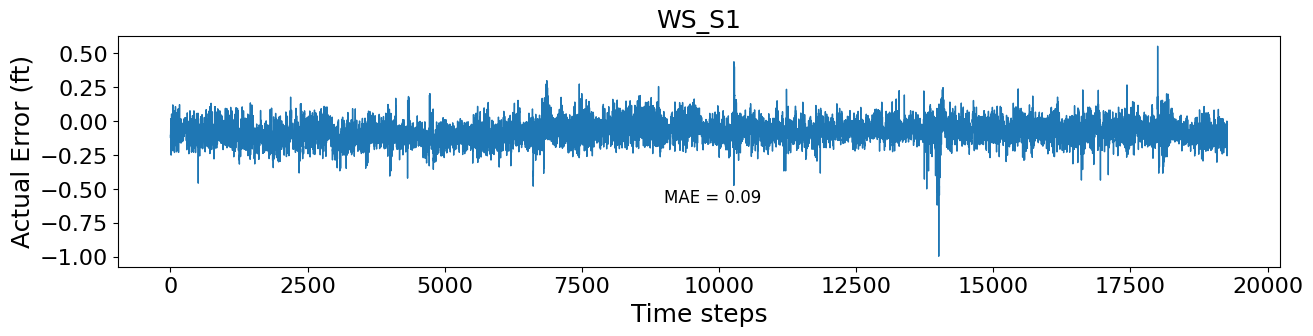

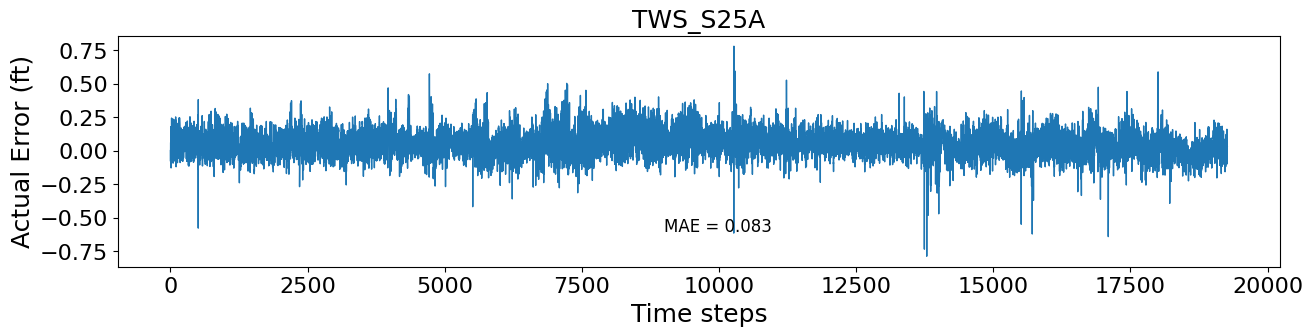

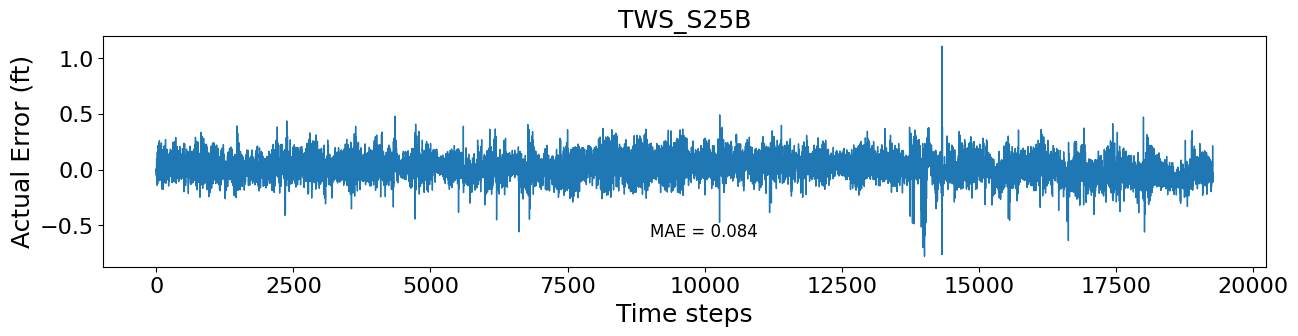

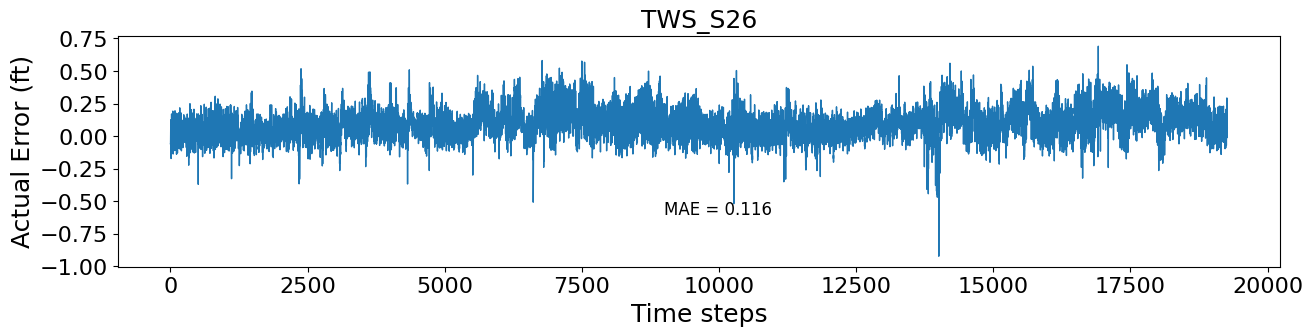

In [10]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [11]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
10
(19268,)
19
(19268,)
17
(19268,)
19


In [12]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
1
(19268,)
12
(19268,)
2
(19268,)
13


In [13]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
9
(19268,)
7
(19268,)
15
(19268,)
6
